## 1. Load Data

#### 1.1 Import images

In [1]:
from scripts.deepgtav.messages import frame2numpy
import numpy as np
import pickle
import bunch
import gzip
import os
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

# open the file
filepath = os.path.join(os.getcwd(), 'data')
filename = "dataset_mini.pz"
pfile = gzip.open(os.path.join(filepath, filename), mode='rb')

[(75, 100, 3), (75, 100, 3)]
dict_keys(['direction', 'throttle', 'brake', 'steering', 'speed', 'yawRate', 'location', 'map', 'frame'])


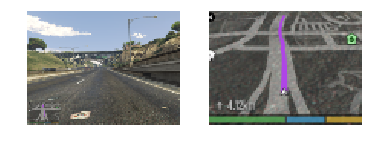

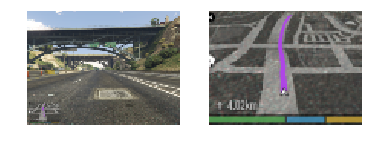

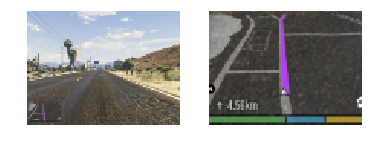

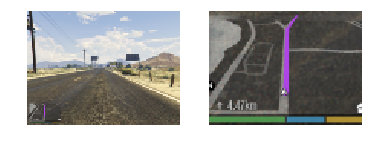

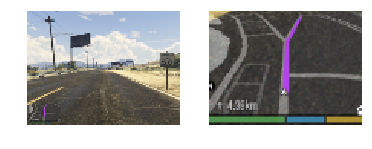

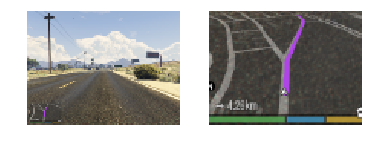

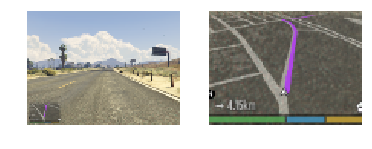

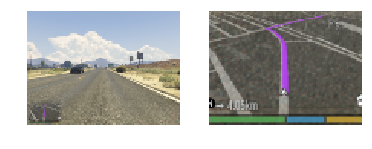

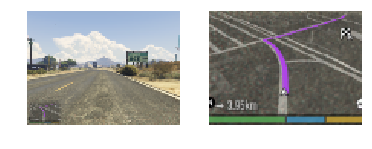

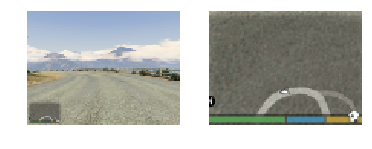

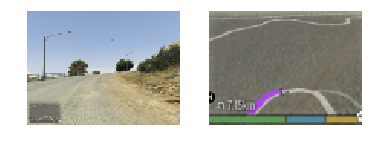

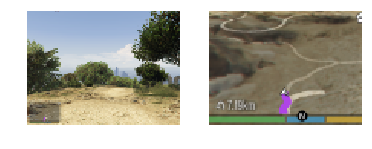

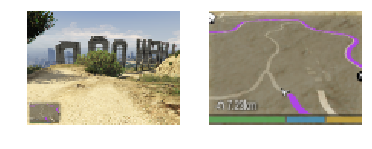

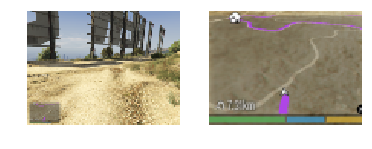

In [2]:
count = 0
no_of_channels = 3

frames_per_weather = 20000
reps_per_weather = 8
frames_per_rep = int(frames_per_weather/reps_per_weather)
image_size = (100, 75)     # required image size
minimap_size = (170, 110)  # current minimaps size

images = []
minimaps = []
outputs = []
speeds = []
yawRates = []

# find resize ratio
diff = []
diff.append(minimap_size[0] - image_size[0])
diff.append(minimap_size[1] - image_size[1])
ratio = 1- (np.min(diff) / minimap_size[np.argmin(diff)])

while True:
    try:
        
        # Load var from pickle
        var = pickle.load(pfile)
        
        # Skip first n frames
        count += 1
        # if count<3000: continue
            
        # Save image, minmap and steering
        image = var['frame']
        image = cv2.resize(image, (100,75))
        images.append(image)
        
        minimap = var['map']
        minimap = cv2.resize(minimap, (100,75))
        minimap = minimap[:,:,:]
        minimaps.append(minimap)
        
        speeds.append(var['speed'])
        yawRates.append(var['yawRate'])
        outputs.append([var['steering'], var['throttle'], var['brake']])
        # outputs.append([var['steering']])
        
        # Display image
        if count % 100 == 0:
            
            plt.subplot(121); plt.imshow(image[:,:,::-1]); plt.axis('off')
            plt.subplot(122); plt.imshow(minimap[:,:,::-1]); plt.axis('off')
            plt.show()
        
        if count == 1: print([image.shape, minimap.shape]); print(var.keys())
        if count>5000: break
            
    except EOFError: break

In [3]:
var['map'].shape

(110, 155, 3)

In [4]:
y = np.array(outputs)[:,0]
print(y.shape)

(1495,)


In [5]:
pick_last_steering = 30
holder = np.zeros((y.shape[0], pick_last_steering))
for i in range(holder.shape[0]):
    count = 0
    for j in range(i, i-pick_last_steering, -1):
        holder[i][count] = y[j-pick_last_steering]*(j>0)
        count += 1
print(holder.shape)

(1495, 30)


In [6]:
images = np.array(images)
minimaps = np.array(minimaps)
speeds = np.array(speeds)
yawRates = np.array(yawRates)
holder = np.array(holder)

# Get inputs and outputs
# x = {}
# x.images = images
# x.minimaps = minimaps
# x = np.concatenate((images, minimaps), axis=1)
# x = [images, minimaps, speeds, yawRates, holder]
x = [images, minimaps, holder]

x_shape = [entity.shape for entity in x]
print('Dataset Shape: x: {} | y: {}'.format(x_shape, y.shape))

Dataset Shape: x: [(1495, 75, 100, 3), (1495, 75, 100, 3), (1495, 30)] | y: (1495,)


## 2. Preprocess Data

#### 2.1 Normalize images to [-1,1]

In [7]:
print([[np.min(entity), np.max(entity)] for entity in x])
if not isinstance(x, np.ndarray): 
    x_new = [(entity/255 - 0.5) * 2 for i, entity in enumerate(x) if i<2]
    if len(x)>=2: x_new = [*x_new, *x[2:]]
    x = x_new
[[np.min(entity), np.max(entity)] for entity in x]

[[0, 255], [0, 255], [-1.0026761244002103, 1.0026761244002103]]


[[-1.0, 1.0], [-1.0, 1.0], [-1.0026761244002103, 1.0026761244002103]]

In [8]:
print(np.min(y), np.max(y))
np.clip(y, -1, 1, out=y)
print(np.min(y), np.max(y))

-1.0026761244002103 1.0026761244002103
-1.0 1.0


#### 2.4 Split data for train and test

In [9]:
seed = 1
np.random.seed(seed)

recv = [None for i in range(2*len(x))]
from sklearn.model_selection import train_test_split
*recv, y_train, y_test = train_test_split(*x, y, test_size=0.2, random_state=np.random, shuffle=True)

x_train = recv[::2]
x_test = recv[1::2]

# print("Train Data | Test Data")
# x_train = [x0_train, x1_train]
# x_test = [x0_test, x1_test]
print(("{0:^10} | {1:^10}").format(x_train[0].shape[0], x_test[0].shape[0]))

   1196    |    299    


## 3. Build Model

#### 3.1 Import Keras and use NCHW mode

In [10]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.metrics import mae
from keras.initializers import RandomNormal

from keras import backend
backend.set_image_dim_ordering('tf')

Using TensorFlow backend.


#### 3.2 Create reusable functions

In [11]:
h = x[0].shape[1]
w = x[0].shape[2]
c = x[0].shape[3]
no_of_classes = y.shape[0]
#print(x.shape, y.shape)

def evaluate_model(model):
    print("\n\n")
    scores = model.evaluate(x_test, y_test)
    print("Accuracy: ", scores[1]*100, "%")
    return scores

#### 3.3 Create a baseline model

In [12]:
def baseline_model():
    
    # Level 1
    image = Input(shape=(h,w,c))
    conv_1_1 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(image)
    conv_1_2 = Conv2D(64, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1_1)
    pool_1_1 = MaxPooling2D(pool_size=(2, 2))(conv_1_2)
    
    # Level 2
    conv_2_1 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1_1)
    conv_2_2 = Conv2D(128, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2_1)
    pool_2_1 = MaxPooling2D(pool_size=(2, 2))(conv_2_2)
    
    # Level 3a
    conv_3a_1 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2_1)
    conv_3a_2 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)
    conv_3a_3 = Conv2D(256, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)
    pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_3a_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1])
    dense_4_1 = Dense(4096, kernel_initializer='normal', activation='tanh')(concat_4_1)
    dense_4_2 = Dense(2048, kernel_initializer='normal', activation='tanh')(dense_4_1)
    dense_4_3 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_4_2)

    model = Model(inputs=[image, prev_steering], outputs=dense_4_3)
    model.compile(loss='mse', optimizer=Adam(lr=0.00001), metrics=[mae,'accuracy'])
    return model

In [32]:
def image_map_steering_concat_model(channels=3):

    h = 75          # height of the image
    w = 100         # width of the image
    c = channels    # no of channels
    
    # Level 1a
    image = Input(shape=(h,w,c))
    conv_1a_1 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(image)#64
    conv_1a_2 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1a_1)#64
    pool_1a_1 = MaxPooling2D(pool_size=(2, 2))(conv_1a_2)
    
    # Level 2a
    conv_2a_1 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1a_1)#128
    conv_2a_2 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2a_1)#128
    pool_2a_1 = MaxPooling2D(pool_size=(2, 2))(conv_2a_2)
    
    # Level 3a
    conv_3a_1 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2a_1)#256
    conv_3a_2 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_1)#256
    conv_3a_3 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3a_2)#256
    pool_3a_1 = MaxPooling2D(pool_size=(2, 2))(conv_3a_3)
    pool_3a_1f = Flatten()(pool_3a_1)
    
    # Level 1c
    maps = Input(shape=(h,w,c))
    conv_1c_1 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh', input_shape=(h,w,c))(maps)
    conv_1c_2 = Conv2D(4, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_1c_1)
    pool_1c_1 = MaxPooling2D(pool_size=(2, 2))(conv_1c_2)
    
    # Level 2c
    conv_2c_1 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_1c_1)
    conv_2c_2 = Conv2D(8, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_2c_1)
    pool_2c_1 = MaxPooling2D(pool_size=(2, 2))(conv_2c_2)
    
    # Level 3c
    conv_3c_1 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(pool_2c_1)
    conv_3c_2 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_1)
    conv_3c_3 = Conv2D(16, kernel_size=3, kernel_initializer='normal', activation='tanh')(conv_3c_2)
    pool_3c_1 = MaxPooling2D(pool_size=(2, 2))(conv_3c_3)
    pool_3c_1f = Flatten()(pool_3c_1)

    # Level 3b
    prev_steering = Input(shape=(pick_last_steering,))
    dense_3b_1 = Dense(40, kernel_initializer='normal', activation='tanh')(prev_steering)

    # Level 4
    concat_4_1 = concatenate([pool_3a_1f, dense_3b_1, pool_3c_1f])
    dense_4_1 = Dense(100, kernel_initializer='normal', activation='tanh')(concat_4_1)#8192
    dense_4_2 = Dense(60, kernel_initializer='normal', activation='tanh')(dense_4_1)#4096
    dense_4_3 = Dense(40, kernel_initializer='normal', activation='tanh')(dense_4_2)#2048
    dense_4_4 = Dense(10, kernel_initializer='normal', activation='tanh')(dense_4_3)#512
    dense_4_5 = Dense(1, kernel_initializer='normal', activation='tanh')(dense_4_4)#

    model = Model(inputs=[image, maps, prev_steering], outputs=dense_4_5)
    model.compile(loss='mse', optimizer=Adam(lr=0.00005), metrics=[mae,'accuracy'])
    return model

In [33]:
model = image_map_steering_concat_model(channels=3)#baseline_model()
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 75, 100, 3)   0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 73, 98, 4)    112         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 73, 98, 4)    112         input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_72 

In [34]:
print(len(x_train))

3


In [35]:
model.fit(x_train, y_train, validation_split=0.1, epochs=10, batch_size=25)
evaluate_model(model)

Train on 1076 samples, validate on 120 samples
Epoch 1/10
1076/1076 [==============================] - 9s 9ms/step - loss: 0.0692 - mean_absolute_error: 0.1074 - acc: 0.0019 - val_loss: 0.0685 - val_mean_absolute_error: 0.1189 - val_acc: 0.0083
Epoch 2/10
1076/1076 [==============================] - 7s 7ms/step - loss: 0.0691 - mean_absolute_error: 0.1073 - acc: 0.0019 - val_loss: 0.0682 - val_mean_absolute_error: 0.1188 - val_acc: 0.0083
Epoch 3/10
1076/1076 [==============================] - 7s 7ms/step - loss: 0.0687 - mean_absolute_error: 0.1072 - acc: 0.0019 - val_loss: 0.0673 - val_mean_absolute_error: 0.1183 - val_acc: 0.0083
Epoch 4/10
1076/1076 [==============================] - 7s 7ms/step - loss: 0.0678 - mean_absolute_error: 0.1071 - acc: 0.0019 - val_loss: 0.0649 - val_mean_absolute_error: 0.1184 - val_acc: 0.0083
Epoch 5/10
1076/1076 [==============================] - 7s 7ms/step - loss: 0.0656 - mean_absolute_error: 0.1090 - acc: 0.0019 - val_loss: 0.0596 - val_mean_abso

[0.04367205145516523, 0.12257776972541841, 0.0]

In [36]:
model.predict(x_train[:10])

array([[-0.03100652],
       [ 0.11909766],
       [-0.0842782 ],
       ...,
       [-0.3397854 ],
       [ 0.04203203],
       [ 0.3365575 ]], dtype=float32)

In [37]:
y_train[:10]

array([-0.00615605, -0.0213119 ,  0.00550172, -0.15797681, -0.01075887,
       -1.        ,  0.08035171,  0.00605054,  0.0898245 , -0.00978698])

## 4. Saving and loading model architecture and weights

#### 4.1 Define reusable functions

In [ ]:
import h5py
from keras.models import model_from_json
from keras.models import load_model

path_models = os.path.join(os.getcwd(), 'models')
valid_model_files = [".h5", ".json"]
weights_suffix = '_weights.h5'
architecture_suffix = '_architecture.json'

In [ ]:
def get_last_file_number(path):
    numbers = [-1]
    for file in os.listdir(path):
        filename = os.path.splitext(file)[0]
        ext = os.path.splitext(file)[1]
        if ext.lower() not in valid_model_files: continue
        if filename.startswith('model_'): 
            numbers.append(int(''.join(list(filter(str.isdigit, filename)))))
    counter = max(numbers)
    return counter

#### 4.2 Save current model

In [ ]:
counter = 0
if not os.path.isdir(path_models): os.makedirs(path_models)
else: counter = get_last_file_number(path_models) + 1

model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + weights_suffix
with open(model_arch_file, 'w+') as json_file:
    json_file.write(model.to_json(indent=4))
# model.save_weights(model_weights_file)

model.save(path_models + '\\' + model_name + '.h5')

print("Saving files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

#### 4.3 Load model from file

In [ ]:
counter = get_last_file_number(path_models)
    
model_name = 'model_' + '{0:03d}'.format(counter)
model_arch_file = path_models + '\\' + model_name + architecture_suffix
model_weights_file = path_models + '\\' + model_name + architecture_suffix

print("Loading files:\n\t" + model_name + architecture_suffix + '\n\t' + model_name + weights_suffix)

if not os.path.isfile(model_arch_file):
    print('Could not find', model_arch_file)
elif not os.path.isfile(model_weights_file):
    print('Could not find', model_weights_file)
else:
    # with open(model_arch_file, 'r') as json_file:
        # model_loaded = model_from_json(json_file.read())
    # model_loaded.load_weights(model_weights_file)
    model_loaded = load_model(path_models + '\\' + model_name + '.h5')

In [ ]:
evaluate_model(model_loaded)